# visualization

> Necessary scripts to visualize orbits

In [ ]:
#| default_exp visualize

In [ ]:
#| export
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
from orbit_generation_testing.reader import get_example_orbit_data
from pytest import raises

In [ ]:
mat_data= get_example_orbit_data()
mat_data.shape

(200, 6, 300)

In [ ]:
mu = 0.0122
system_points={
    'Moon': (1-mu,0,0),
    'Earth': (-mu,0,0),
    'Lagrange 1': (0.8369,0,0),
    'Lagrange 2': (1.1557,0,0)
}

## Static

In [ ]:
#| export
def visualize_static_orbits(data, time_instants=None, orbit_indices=None, show_legend=False, point_dict=None):
    """
    Visualizes orbits and highlights specified time instants for every orbit in orbit_indices with data shape (num_orbits, 6, num_time_points).

    :param data: numpy.ndarray, shape (num_orbits, 6, num_time_points), containing orbit data.
    :param time_instants: Optional[list[int]], time instants to highlight across selected orbits. If None or empty, no highlights are made.
    :param orbit_indices: Optional[list], indices of the orbits to visualize and highlight. If None, uses all orbits.
    :param show_legend: Optional[bool], indicates whether to show the legend.
    :param point_dict: Optional[dict], dictionary where keys are point names and values are the 3D coordinates of the points.
    """
    
    if time_instants is None:
        time_instants = []  # Ensure time_instants is a list if None is provided
    
    # Validate time instants before plotting
    max_time_instants = data.shape[2]
    for time_instant in time_instants:
        if time_instant < 0 or time_instant >= max_time_instants:
            raise ValueError(f"Time instant {time_instant} is out of range.")
    
    # Validate orbit indices before plotting
    num_orbits = data.shape[0]
    if orbit_indices is None:
        orbit_indices = range(num_orbits)  # Default to all orbits
    else:
        for index in orbit_indices:
            if index < 0 or index >= num_orbits:
                raise ValueError(f"Orbit index {index} is out of range.")
    
    # Proceed with plotting after successful validation
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for index in orbit_indices:
        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates
        ax.plot(X, Y, Z, label=f'Orbit {index}', alpha=0.5)  # Plot orbits with reduced alpha to emphasize highlights

        # Highlight the specified time instants for each orbit, if any
        if time_instants:
            for time_instant in time_instants:
                posx, posy, posz = data[index, 0:3, time_instant]
                ax.scatter(posx, posy, posz, color='red', s=100, zorder=5)
    
    # Plot additional points if point_dict is provided
    if point_dict:
        for point_name, coords in point_dict.items():
            ax.scatter(*coords, label=point_name, s=100, depthshade=True)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Orbits Static Visualization')

    if show_legend:
        ax.legend()

    plt.show()

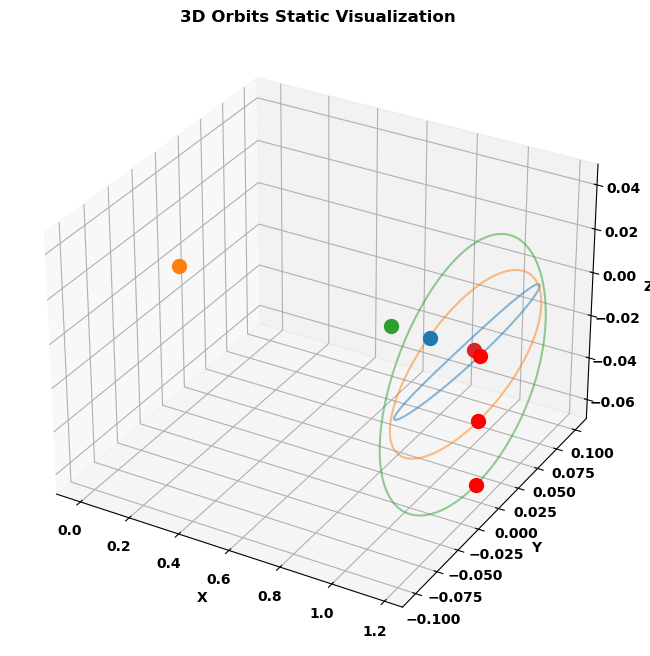

In [ ]:
visualize_static_orbits(data= mat_data,time_instants=[0], orbit_indices=[0,20,40], point_dict=system_points)

In [ ]:
#| test "invalid time_instants raises ValueError"
time_instants = [-1, 11]  # Out of bounds
with raises(ValueError):
    visualize_static_orbits(mat_data, time_instants)

#| test "invalid orbit_indices raises ValueError"
time_instants = [0, 9]  # Valid
orbit_indices = [201]  # Out of bounds
with raises(ValueError) as exception_info:
    visualize_static_orbits(mat_data, time_instants, orbit_indices)
assert "Orbit index 201 is out of range." in str(exception_info.value)

## Dynamic

In [ ]:
#| export
def export_dynamic_orbits_html(data, time_instants=None, orbit_indices=None, point_dict=None, filename='orbits.html'):
    """
    Visualize orbits in 3D and save as an interactive HTML file with a clickable legend, for data organized as (num_orbits, 6, num_time_points).
    Includes the option to add named points to the visualization and highlights the positions of each orbit at given time_instants.

    :param data: Numpy array of shape (num_orbits, 6, num_time_points)
    :param time_instants: Optional[List of int], the time instants to highlight across all orbits. If None or empty, no highlights are made.
    :param orbit_indices: Optional; List of indices of the orbits to visualize
    :param filename: String, name of the file to save the HTML plot
    :param point_dict: Optional; Dictionary where keys are point names and values are the 3D coordinates of the points
    """
    if time_instants is None:
        time_instants = []  # Ensure time_instants is a list if None is provided

    num_orbits = data.shape[0]  # Adjusted for the new data shape
    if orbit_indices is None:
        orbit_indices = range(num_orbits)  # Default to all orbits

    fig = go.Figure()

    # Plot each orbit
    for index in orbit_indices:
        if index < 0 or index >= num_orbits:
            raise ValueError(f"Orbit index {index} is out of range.")
        
        # Extract coordinates
        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates

        fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='lines',
                                   name=f'Orbit {index}',
                                   legendgroup=f'orbit{index}',
                                   showlegend=True))

        # Highlight the positions at the given time_instants, if any
        if time_instants:
            for timestamp in time_instants:
                if timestamp < 0 or timestamp >= data.shape[2]:
                    raise ValueError(f"The provided timestamp {timestamp} is out of range.")
                highlight_x = [data[index, 0, timestamp]]
                highlight_y = [data[index, 1, timestamp]]
                highlight_z = [data[index, 2, timestamp]]
                fig.add_trace(go.Scatter3d(x=highlight_x, y=highlight_y, z=highlight_z, mode='markers',
                                           marker=dict(size=5, color='red'),
                                           name=f'Highlight {index} @ {timestamp}',
                                           legendgroup=f'orbit{index}',
                                           showlegend=False))

    # Add points from the point_dict if provided
    if point_dict is not None:
        for point_name, coords in point_dict.items():
            fig.add_trace(go.Scatter3d(x=[coords[0]], y=[coords[1]], z=[coords[2]], mode='markers',
                                       marker=dict(size=5),
                                       name=point_name))

    fig.update_layout(title='3D Orbits Visualization',
                      scene=dict(xaxis_title='X',
                                 yaxis_title='Y',
                                 zaxis_title='Z'),
                      width=800, height=600,
                      legend_title="Orbits Legend",
                      clickmode='event+select')

    fig.write_html(filename)
    print(f"Visualization saved to {filename}")



In [ ]:
export_dynamic_orbits_html(data=mat_data, point_dict= system_points, time_instants=[0], orbit_indices=[1])

Visualization saved to orbits.html


In [ ]:
#| test "invalid time_instants raises ValueError"
data = np.zeros((3, 6, 50))  # Dummy data with 3 orbits, 6 parameters, 50 time points
time_instants = [-1, 51]  # Invalid time_instants
orbit_indices = [0, 1]  # Valid orbit indices
filename = 'test_orbits.html'  # Filename for saving the HTML
with raises(ValueError):
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)

#| test "invalid orbit_indices raises ValueError"
time_instants = [10, 20]  # Valid time_instants
orbit_indices = [3, 4]  # Invalid orbit indices (out of range for given data)
with raises(ValueError):
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()